In [1]:
## Visualisation for Multivariate Convolutional Long Short-Term Memory model (M-ConvLSTM)
## by Jimmy Cheung

In [2]:
## No need to carry out multiple (30) experiments and calculate RMSE, MAE, MAPE here
## No need to ask for model specification here, if wish to change parameters please do so manually

In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt   
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
class Time_Series_Dataset(Dataset):
	def __init__(self, inputs, outputs):
		self.inputs = inputs
		self.outputs = outputs

	def __len__(self):
		return len(self.inputs)

	def __getitem__(self, idx):
		x = self.inputs[idx]
		y = self.outputs[idx]
		return (torch.tensor(x, dtype = torch.float32), torch.tensor(y, dtype = torch.float32))

In [5]:
class ConvLSTM(nn.Module):
	def __init__(self, num_features, hidden_sizes, num_layers, output_size, 
		num_filters, kernel_size):
		super(ConvLSTM, self).__init__()
		self.hidden_sizes = hidden_sizes
		self.num_layers = num_layers

		# Convolutional layer
		self.conv1 = nn.Conv1d(in_channels = num_features, 
			out_channels = num_filters, kernel_size = kernel_size)
		self.lstms = nn.ModuleList()
		self.lstms.append(nn.LSTM(num_filters, hidden_sizes[0], 
			batch_first=True, bidirectional=True))

		for i in range(1, num_layers):
			self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], 
				batch_first=True, bidirectional=True))

		self.fc1 = nn.Linear(hidden_sizes[-1] * 2, 20)  # Fully connected layer
		self.fc2 = nn.Linear(20, output_size)

	def forward(self, x):
		# Convolutional layer expects input of shape 
		x = x.permute(0, 2, 1) # (batch_size, in_channels, seq_length)
		x = torch.relu(self.conv1(x))
		# Convert back to (batch_size, seq_length, num_filters)
		x = x.permute(0, 2, 1)  
		h = x
		for lstm in self.lstms:
			out, _ = lstm(h)
			h = out
		out = torch.relu(self.fc1(out[:, -1, :]))
		out = self.fc2(out)
		return out

In [6]:
# Multivariate data processing
def split_data(data, input_size, output_size, train_ratio, seed):
	# 1. split data into input features (X) and output (y)
	X, y = [], []
	total_size = input_size + output_size
	for i in range(len(data) - total_size + 1):
		X.append(features[i:i+input_size])
		y.append(target[i+input_size:i+total_size])
	# 2. shuffle batches and split into train/test
	X_train, X_test, y_train, y_test = train_test_split(X, y, 
		train_size = train_ratio, random_state = seed)
	return X_train, X_test, y_train, y_test

In [7]:
# DATA HANDLING - CHANGE DATA AS DESIRED

# data = 'bitcoin'
data = 'ethereum'

if data == 'bitcoin':
    df = pd.read_csv('../data/bitcoin.csv')
else:
    df = pd.read_csv('../data/ethereum.csv')
df = df.drop(columns = ['Adj Close'])
features = df[['High', 'Low', 'Open', 'Close', 'Volume']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = df['Close']
target_reshaped = np.array(target).reshape(-1,1) # normalise output
scaler = MinMaxScaler(feature_range=(0,1)) 
target = scaler.fit_transform(target_reshaped).flatten()

In [8]:
# PARAMETERS - we are setting fixed values here (same values as our paper)
input_size = 6
output_size = 5
train_ratio = 0.7
seed = 5925
num_features = 5 # multivariate time series

hidden_neurons = [64, 32]
num_layers = len(hidden_neurons)
num_filters = 64
kernel_size = 2
num_epochs = 100

In [9]:
# shuffle and sort data into input [10, 20, 30] and output [40, 50]
X_train, X_test, y_train, y_test = split_data(df, input_size, output_size, train_ratio, seed)

# torch.tensor wrap X_train, X_test, y_train, y_test to feed DataLoader
df_train = Time_Series_Dataset(X_train, y_train)
df_test = Time_Series_Dataset(X_test, y_test)

# DataLoader -> model
# changing batch size affect model accuracy significantly (future work)
# shuffle = False to maintain sequence structure within input_window
df_train = DataLoader(df_train, batch_size = 16, shuffle = False)
df_test = DataLoader(df_test, batch_size = 16, shuffle = False)

# use ConvLSTM
model = ConvLSTM(num_features, hidden_neurons, num_layers, output_size, num_filters, kernel_size)
criterion = nn.MSELoss() # related work (MSE & ADAM = 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) 

In [10]:
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in df_train:
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, targets)
        optimizer.zero_grad() # backward & optimise
        loss.backward()
        optimizer.step()

In [11]:
# MODEL TESTING
model.eval() # evaluate the model on the test set
y_pred, y_test = [], []

with torch.no_grad(): # disables gradient computation - no more improving
    for inputs, targets in df_test:
        outputs = model(inputs)
        # call cpu for safe conversion
        y_pred.append(outputs.detach().cpu().numpy())
        y_test.append(targets.detach().cpu().numpy())

y_pred = np.concatenate(y_pred, axis = 0) # convert lists to arrays
y_test = np.concatenate(y_test, axis = 0)

# inverse transform (get back to original scale)
pred_vals = torch.tensor(scaler.inverse_transform(y_pred)) 
act_vals = torch.tensor(scaler.inverse_transform(y_test)) 

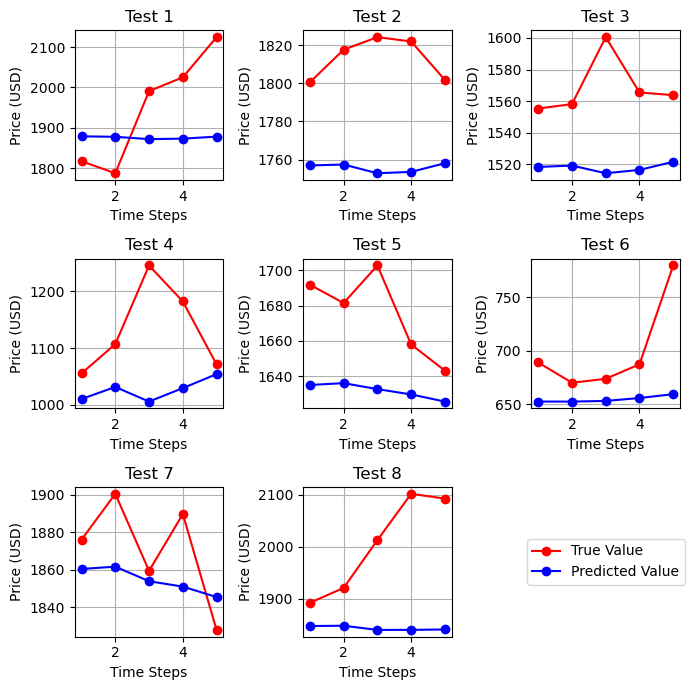

In [12]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, act_vals[i], marker='o', linestyle='-', color='red', label='True Value')
    ax.plot(time_steps, pred_vals[i], marker='o', linestyle='-', color='blue', label='Predicted Value')
    ax.set_title(f'Test {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  
    
# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()

if data == 'bitcoin':
    # very similar results to BTC-U-Linear.png, but there are differences (e.g. see Horizon 8)
    plt.savefig('results/convlstm/multivariate/BTC-M-CLSTM.png')
else: 
    plt.savefig('results/convlstm/multivariate/ETH-M-CLSTM.png')

plt.show()
plt.close()